In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
dep = pd.read_csv('../data/establecimientos_en_carretera.txt',
                  delimiter='\t')

/home/rdora/miniconda3/envs/femec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,26,28,30,33,34,39,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [82]:
pob = pd.read_csv('../data/casos_ajustado_poblacion.txt', delimiter='\t')

In [37]:
def get_only_numbers(x):
    try:
        r = int(x)
        return r
    except ValueError:
        return -1

In [53]:
def get_codes(x):
    good_codes = ['72', '461']
    x = str(x)
    for code in good_codes:
        if x.startswith(code):
            return True
        else:
            return False

In [83]:
dep.cve_mun = dep.cve_mun.apply(get_only_numbers)

dep.cve_ent = dep.cve_ent.apply(get_only_numbers)

dep = dep[dep.cve_ent >= 0]

dep = dep[dep.cve_mun >= 0]

In [84]:
dep['CVEGEO'] = (dep.cve_ent.astype(int).astype(str) +
                 dep.cve_mun.astype(str).str.zfill(3)).astype(int)

In [85]:
dep = dep[dep.tipo_vial=='CARRETERA']

dep = dep[dep.codigo_act.apply(get_codes)]

In [86]:
pob = pob[['CVEGEO',
          'estado',
          'nombre',
          'poblacion_total']]

cols2keep = ['id',
             'nom_estab',
             'per_ocu',
             'codigo_act',
             'latitud',
             'longitud',
             'CVEGEO']

dep = dep[cols2keep]

In [87]:
dep = pd.merge(dep, pob, how='left')

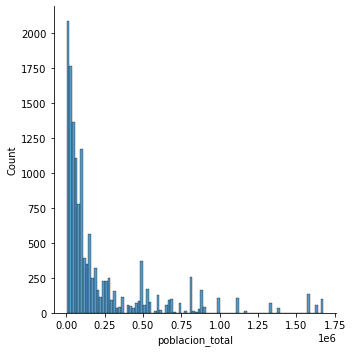

In [88]:
sns.displot(dep.poblacion_total)

# Highway muns

In [216]:
muns = pd.read_csv('../data/muns_highways.tsv', sep='\t')

muns  = pd.merge(muns, pob, how='left')

In [96]:
cases = pd.read_csv('../data/casos_ajustado_poblacion.txt', sep='\t')

In [102]:
dates = sorted(cases.columns[11:])

In [107]:
M = cases[dates].values

<AxesSubplot:>

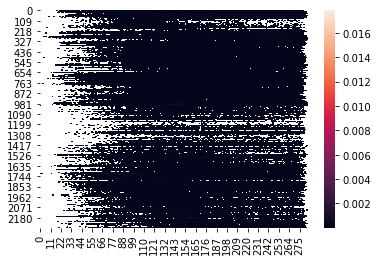

In [108]:
sns.heatmap(M)

In [111]:
df_melt = pd.melt(cases, id_vars='CVEGEO', value_vars=dates)

In [125]:
df_pivot = pd.pivot(df_melt, columns='CVEGEO', index='variable', values='value')

In [128]:
def get_first_case(x):
    return x.first_valid_index()

In [186]:
def get_last_cumsum(x):
    return x.last_valid_index()

In [269]:
def get_date_percentage(x):
    try:
        date = x[x.gt(.0001)].index[0]
        return date
    except IndexError:
        return np.nan

In [219]:
first_cases = df_pivot.apply(get_first_case, axis=0).rename('first_case').reset_index()

df_cum = df_pivot.cumsum()

df_cumsum = df_cum.ffill(axis=0).iloc[-1,:].rename('agg_cases').reset_index()

first_cases = pd.merge(first_cases, df_cumsum, how='left')

In [220]:
muns = muns[['CVEGEO']]

muns['is_carretero'] = True

In [221]:
first_cases = pd.merge(first_cases, muns, how='left')

first_cases['is_carretero'] = first_cases.is_carretero.fillna(False)

In [224]:
first_cases = pd.merge(first_cases, pob, how='left')

first_cases['first_case'] = pd.to_datetime(first_cases['first_case'])

first_cases['day_first_case'] = first_cases['first_case'].dt.dayofyear

df_per = df_pivot.apply(get_date_percentage, axis=0).rename('date_01').reset_index()

first_cases = pd.merge(first_cases, df_per, how='left')

first_cases['date_01'] = pd.to_datetime(first_cases.date_01)

first_cases['days_to_01'] = (first_cases['date_01'] - first_cases['first_case']).dt.days

## Tests

In [300]:
np.random.seed(42)
sample_mean = []
min_carr = 851
max_carr = 184239
not_carr = first_cases[first_cases['is_carretero'] == False]
for i in range(1000):
    idx = np.random.choice(not_carr.shape[0], muns.shape[0])
    chunk = not_carr.iloc[idx]
    sample_mean.append(chunk['days_to_01'].mean())

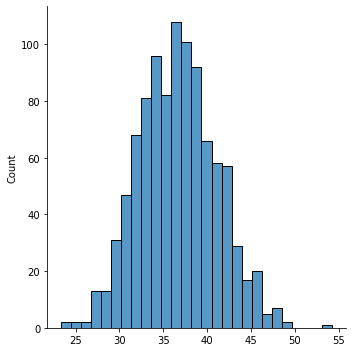

In [302]:
sns.displot(sample_mean)

In [295]:
first_cases.groupby('is_carretero').poblacion_total.describe()

,count,mean,std,min,25%,50%,75%,max
is_carretero,,,,,,,,
False,2120.0,54940.910849,148552.399389,87.0,5637.75,15781.5,39075.25,1827868.0
True,146.0,18316.589041,25752.687484,851.0,4090.50,10216.0,21673.75,184239.0


In [288]:
first_cases.head()

,CVEGEO,first_case,agg_cases,is_carretero,estado,nombre,poblacion_total,day_first_case,date_01,days_to_01
0,1001,2020-03-07,0.011991,False,Aguascalientes,Aguascalientes,877190.0,67.0,2020-10-12,219.0
1,1002,2020-03-15,0.004283,False,Aguascalientes,Asientos,46464.0,75.0,2020-07-01,108.0
2,1003,2020-04-20,0.006423,False,Aguascalientes,Calvillo,56048.0,111.0,2020-07-06,77.0
3,1004,2020-05-07,0.006291,False,Aguascalientes,Cosío,15577.0,128.0,2020-05-11,4.0
4,1005,2020-03-23,0.003463,False,Aguascalientes,Jesús María,120405.0,83.0,NaT,NaN


In [303]:
first_cases.to_csv('../data/municipios.tsv', index=False, sep='\t')

In [291]:
first_cases.groupby('is_carretero').mean()

,CVEGEO,agg_cases,poblacion_total,day_first_case,days_to_01
is_carretero,,,,,
False,19140.977549,0.004344,54940.910849,133.993396,36.709038
True,20438.810811,0.004286,18316.589041,138.712329,24.211382


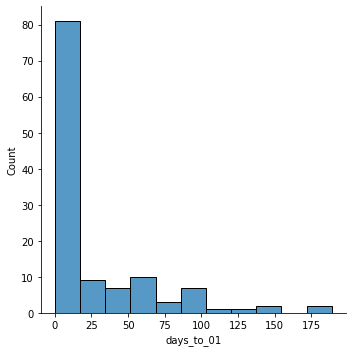

In [292]:
sns.displot(first_cases[first_cases.is_carretero==True].days_to_01)

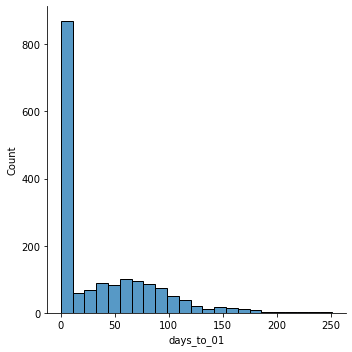

In [293]:
sns.displot(first_cases[first_cases.is_carretero!=True].days_to_01)

In [225]:
first_cases

,CVEGEO,first_case,agg_cases,is_carretero,estado,nombre,poblacion_total
0,1001,2020-03-07,0.011991,False,Aguascalientes,Aguascalientes,877190.0
1,1002,2020-03-15,0.004283,False,Aguascalientes,Asientos,46464.0
2,1003,2020-04-20,0.006423,False,Aguascalientes,Calvillo,56048.0
3,1004,2020-05-07,0.006291,False,Aguascalientes,Cosío,15577.0
4,1005,2020-03-23,0.003463,False,Aguascalientes,Jesús María,120405.0
...,...,...,...,...,...,...,...
2281,32054,2020-04-27,0.003289,False,Zacatecas,Villa Hidalgo,19155.0
2282,32055,2020-03-17,0.007970,False,Zacatecas,Villanueva,30240.0
2283,32056,2020-03-09,0.027992,False,Zacatecas,Zacatecas,146147.0
2284,32057,2020-04-16,0.007469,False,Zacatecas,Trancoso,19413.0


In [ ]:
df_cum.apply(pd.las)

In [185]:
df_cum

CVEGEO,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,32049,32050,32051,32052,32053,32054,32055,32056,32057,32058
variable,,,,,,,,,,,,,,,,,,,,,
2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.011991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.007937,0.027801,0.007418,NaN
2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.006329,NaN,NaN,NaN,NaN,0.007970,0.027903,0.007469,NaN
2020-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.005815,NaN,0.002748,NaN,NaN,0.027979,NaN,NaN


In [182]:
df_pivot

CVEGEO,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,32049,32050,32051,32052,32053,32054,32055,32056,32057,32058
variable,,,,,,,,,,,,,,,,,,,,,
2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000165,0.000109,0.000052,NaN
2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000102,NaN,NaN,NaN,NaN,0.000033,0.000103,0.000052,NaN
2020-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000028,NaN,0.000076,NaN,NaN,0.000075,NaN,NaN


In [181]:
np.nansum(df_pivot.values, axis=1)

array([2.32480826e-06, 1.10464891e-06, 1.10464891e-06, 1.42707504e-06,
       4.15231304e-06, 8.58754617e-07, 2.19569224e-06, 1.67025772e-06,
       9.61661443e-07, 4.21607307e-06, 3.26298799e-06, 2.51789210e-06,
       1.39895570e-05, 2.23151465e-05, 1.65168095e-05, 1.72785159e-05,
       1.80321496e-05, 2.57332203e-05, 6.19131666e-05, 6.64821082e-05,
       2.18777131e-04, 4.69774578e-04, 1.58074079e-04, 2.77673314e-04,
       2.37848442e-04, 2.91281531e-04, 3.38486844e-04, 9.53278184e-04,
       8.09670804e-04, 5.29572863e-04, 5.91854238e-04, 5.42132102e-04,
       1.32891364e-03, 3.22089642e-03, 1.14727720e-03, 1.44792353e-03,
       1.29089070e-03, 1.20110437e-03, 2.06451939e-03, 1.54978768e-03,
       2.51281918e-03, 2.45371507e-03, 2.45829373e-03, 3.52434759e-03,
       2.43863969e-03, 2.63981153e-03, 3.75029492e-03, 2.29952258e-03,
       2.89187501e-03, 3.22796338e-03, 3.60057469e-03, 2.69364931e-03,
       7.07851312e-03, 3.62373291e-03, 4.85668164e-03, 5.92691345e-03,
      

In [174]:
df_pivot

CVEGEO,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,32049,32050,32051,32052,32053,32054,32055,32056,32057,32058
variable,,,,,,,,,,,,,,,,,,,,,
2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000165,0.000109,0.000052,NaN
2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000102,NaN,NaN,NaN,NaN,0.000033,0.000103,0.000052,NaN
2020-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000028,NaN,0.000076,NaN,NaN,0.000075,NaN,NaN


In [173]:
first_cases

,CVEGEO,first_case
0,1001,2020-03-07
1,1002,2020-03-15
2,1003,2020-04-20
3,1004,2020-05-07
4,1005,2020-03-23
...,...,...
2281,32054,2020-04-27
2282,32055,2020-03-17
2283,32056,2020-03-09
2284,32057,2020-04-16


In [169]:
cases = pd.read_csv('../data/factores_covid_municipio.tsv', sep='\t')

In [151]:
cases['day_10_deaths'] = pd.to_datetime(cases['day_10_deaths'])
cases['day_first_case'] = pd.to_datetime(cases['day_first_case'])
cases['day_50_cases'] = pd.to_datetime(cases['day_50_cases'])
cases['day_first_death'] = pd.to_datetime(cases['day_first_death'])

In [153]:
cases['diff_50_cases'] = cases['day_50_cases'] - cases['day_first_case']
cases['diff_10_deaths'] = cases['day_10_deaths'] - cases['day_first_case']

In [156]:
muns['is_carretero'] = True

In [159]:
muns = muns.rename(columns={'CVEGEO': 'municipality_id'})

In [161]:
muns = muns[['municipality_id', 'is_carretero']]

In [163]:
cases = pd.merge(cases, muns, how='left')

In [166]:
muns

,municipality_id,is_carretero
0,2005,True
1,5008,True
2,5012,True
3,5014,True
4,7007,True
...,...,...
153,30155,True
154,30175,True
155,30197,True
156,30210,True


In [154]:
cases

,municipality_id,municipality,max_cases,max_hospitalized,max_deaths,day_first_case,day_first_death,day_50_cases,day_10_deaths,total_cases,total_deaths,diff_50_cases,diff_10_deaths
0,1001,Aguascalientes,201,29,16,2020-03-14,2020-04-10,2020-04-06,2020-05-06,8952,852,23 days,53 days
1,1005,Jesús María,9,4,4,2020-03-23,2020-05-17,2020-06-15,2020-09-05,391,29,84 days,166 days
2,1006,Pabellón de Arteaga,12,3,3,2020-03-23,2020-05-17,2020-06-05,2020-08-29,424,27,74 days,159 days
3,1007,Rincón de Romos,14,5,2,2020-03-30,2020-06-06,2020-06-01,2020-09-20,516,16,63 days,174 days
4,1011,San Francisco de los Romo,5,2,1,2020-04-20,2020-05-07,2020-08-09,2020-10-08,112,13,111 days,171 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,32039,Río Grande,8,5,2,2020-04-29,2020-05-10,2020-07-10,2020-07-17,335,47,72 days,79 days
579,32042,Sombrerete,26,2,1,2020-03-20,2020-05-17,2020-07-31,2020-08-30,489,25,133 days,163 days
580,32050,Vetagrande,3,3,2,2020-07-07,2020-07-14,2020-11-04,2020-10-14,51,12,120 days,99 days
581,32056,Zacatecas,66,13,5,2020-03-24,2020-05-02,2020-05-22,2020-06-20,3424,234,59 days,88 days
